 Loaded: 440 samples, 174 columns
 Identified 150 VOC columns.
 110 VOCs retained after missingness filter.
 68 VOCs significantly differ from blanks (p<0.05).
Proximity matrix computed.


/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


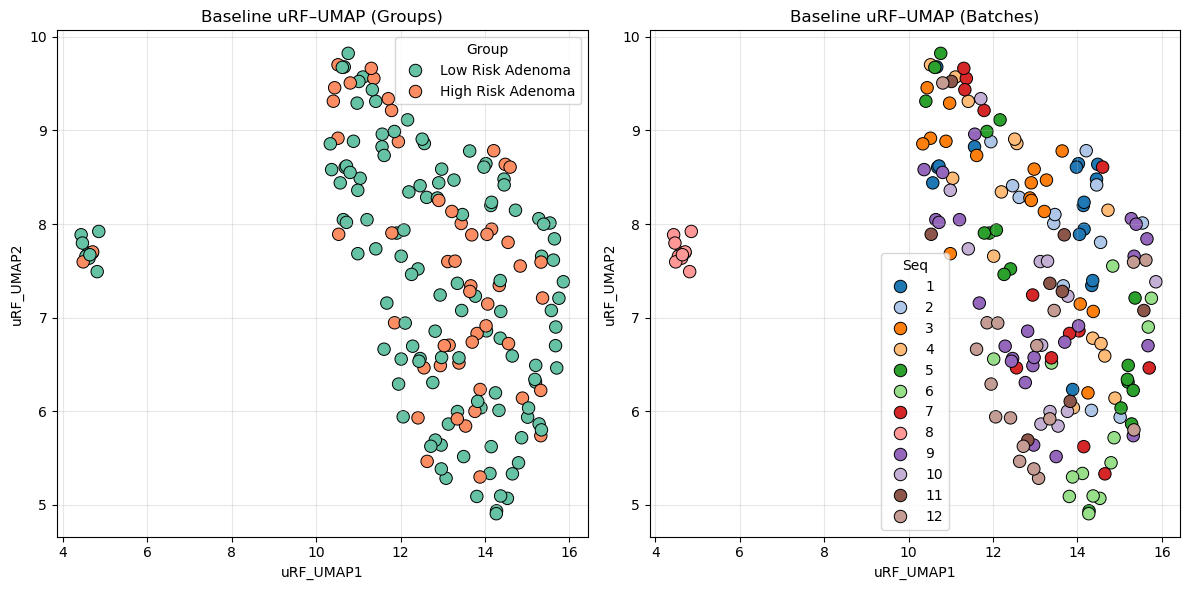

[neuroCombat] Creating design matrix
[neuroCombat] Standardizing data across features
[neuroCombat] Fitting L/S model and finding priors
[neuroCombat] Finding parametric adjustments
[neuroCombat] Final adjustment of data
ComBat batch correction complete.
Proximity matrix computed.


/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


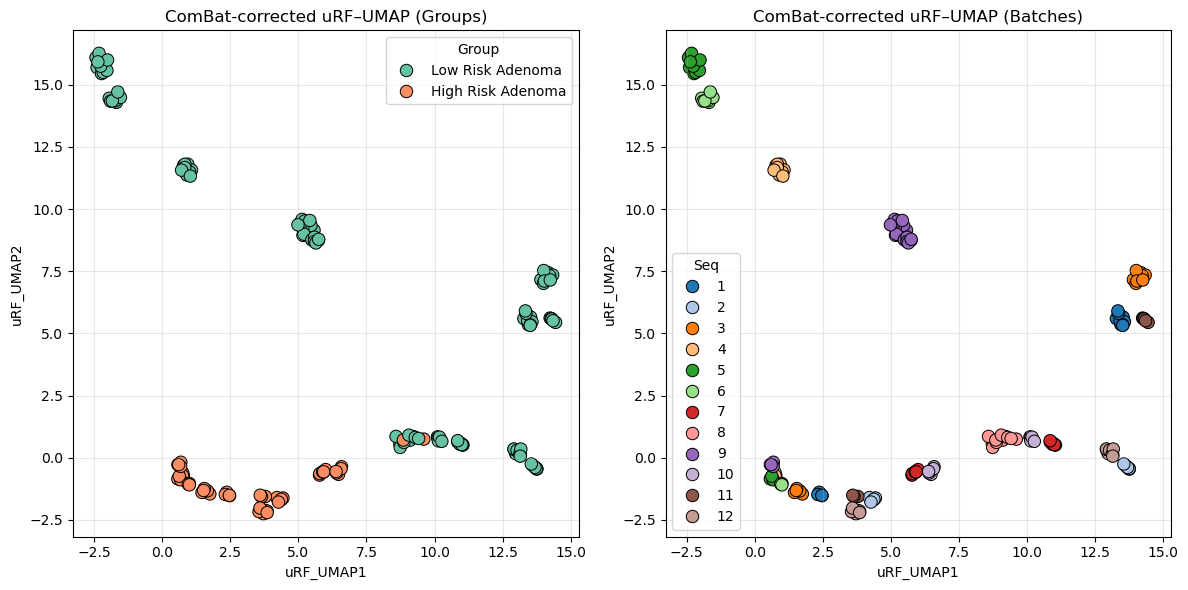

PCA smoothing complete (50 components).
Proximity matrix computed.


/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


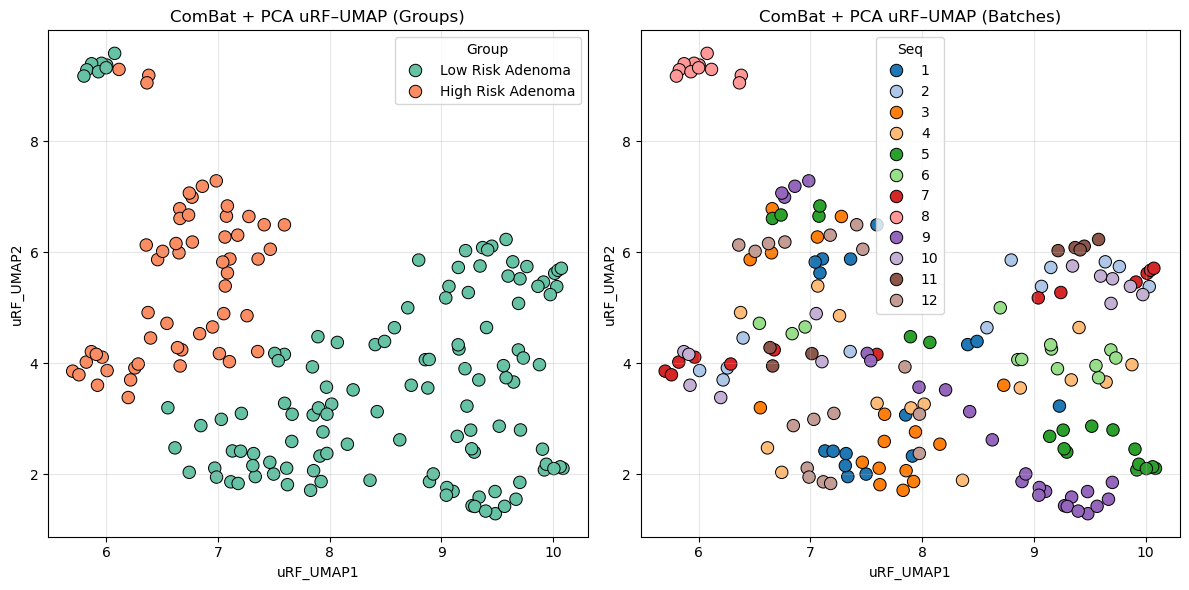

Global Z-score normalization complete.
Proximity matrix computed.


/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


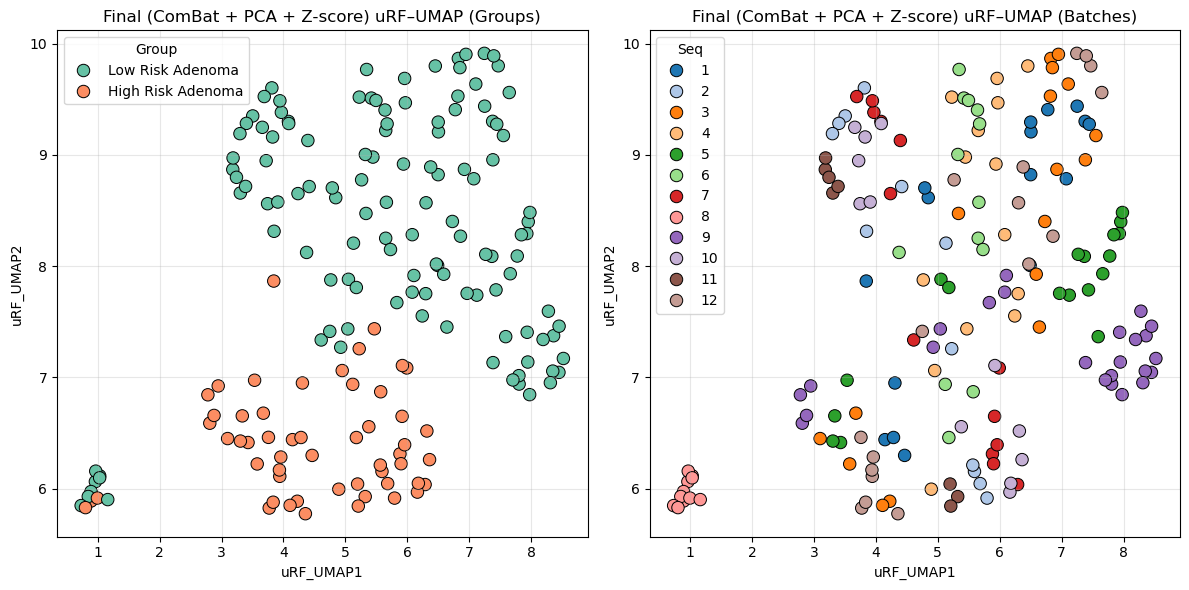

Silhouette (Group): 0.274 | Silhouette (Batch): -0.052


In [ ]:
# ============================================================
# UNIFIED PIPELINE — Baseline → ComBat → PCA → PCA+Zscore
# ============================================================


#This notebook provides a **unified and modular implementation** of the uRF–UMAP workflow 
#for exploring the intrinsic structure of VOC (Volatile Organic Compound) data.

#Goal : To evaluate how different preprocessing strategies influence the biological vs. technical structure in VOC profiles.  

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from neuroCombat import neuroCombat
from scipy.stats import mannwhitneyu
import umap

# -----------------------------
# Utility Functions
# -----------------------------

def preprocess_data(filepath, na_labels):
    """Load and clean the dataset."""
    df = pd.read_excel(filepath, engine="openpyxl", na_values=na_labels)
    print(f" Loaded: {df.shape[0]} samples, {df.shape[1]} columns")

    # Standardize blanks and subgroups
    df.loc[df["Label"] == "EquipmentBlank", "Study subgroup"] = 0
    df.loc[df["Label"] == "AmbientBlank", "Study subgroup"] = 1
    df = df[df["Study subgroup"] != "NOT FOUND"]
    df["Study subgroup"] = pd.to_numeric(df["Study subgroup"], errors="coerce")

    return df


def get_voc_columns(df, start_marker="2-Pentene, (Z)"):
    """Identify VOC feature columns."""
    start_idx = df.columns.get_loc(start_marker)
    voc_cols = df.columns[start_idx:]
    df[voc_cols] = df[voc_cols].apply(pd.to_numeric, errors="coerce")
    print(f" Identified {len(voc_cols)} VOC columns.")
    return voc_cols


def filter_vocs(df_real, voc_cols, threshold=30):
    """Filter and impute missing VOCs."""
    cols_to_keep = []
    for col in voc_cols:
        pct2 = df_real.loc[df_real["Study subgroup"] == 2, col].isna().mean() * 100
        pct3 = df_real.loc[df_real["Study subgroup"] == 3, col].isna().mean() * 100
        if pct2 > threshold and pct3 > threshold:
            continue
        cols_to_keep.append(col)

        med2 = df_real.loc[df_real["Study subgroup"] == 2, col].median()
        med3 = df_real.loc[df_real["Study subgroup"] == 3, col].median()
        df_real.loc[df_real["Study subgroup"] == 2, col] = df_real.loc[df_real["Study subgroup"] == 2, col].fillna(med2 if not np.isnan(med2) else med3)
        df_real.loc[df_real["Study subgroup"] == 3, col] = df_real.loc[df_real["Study subgroup"] == 3, col].fillna(med3 if not np.isnan(med3) else med2)

    print(f" {len(cols_to_keep)} VOCs retained after missingness filter.")
    return cols_to_keep


def mann_whitney_filter(df_real, df_blanks, vocs):
    """Select VOCs significantly different from blanks."""
    significant = []
    for col in vocs:
        real_vals = df_real[col].dropna()
        blank_vals = df_blanks[col].dropna()
        if len(real_vals) > 2 and len(blank_vals) > 2:
            _, pval = mannwhitneyu(real_vals, blank_vals, alternative="two-sided")
            if pval < 0.05:
                significant.append(col)
    print(f" {len(significant)} VOCs significantly differ from blanks (p<0.05).")
    return significant


def compute_proximity(rf, X):
    """Compute proximity matrix from trained RF."""
    leaf_indices = rf.apply(X)
    n_trees = leaf_indices.shape[1]
    n_samples = leaf_indices.shape[0]
    proximity = np.zeros((n_samples, n_samples))
    for tree in range(n_trees):
        leaves = leaf_indices[:, tree]
        for leaf in np.unique(leaves):
            idx = np.where(leaves == leaf)[0]
            proximity[np.ix_(idx, idx)] += 1
    proximity /= n_trees
    return proximity


def run_urf_umap(X, df_meta, title_prefix=""):
    """Train unsupervised RF, compute proximity, and run UMAP embedding."""
    X_perm = np.random.permutation(X)
    y_unsup = np.concatenate([np.ones(len(X)), np.zeros(len(X_perm))])
    X_comb = np.vstack([X, X_perm])

    rf = RandomForestClassifier(
        n_estimators=1000,
        max_features="sqrt",
        min_samples_leaf=2,
        n_jobs=-1,
        random_state=42
    )
    rf.fit(X_comb, y_unsup)

    proximity = compute_proximity(rf, X)
    print("Proximity matrix computed.")

    reducer = umap.UMAP(
        n_neighbors=15,
        min_dist=0.1,
        metric="precomputed",
        random_state=42
    )
    embedding = reducer.fit_transform(1 - proximity)
    df_meta["uRF_UMAP1"], df_meta["uRF_UMAP2"] = embedding[:, 0], embedding[:, 1]

    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    sns.scatterplot(data=df_meta, x="uRF_UMAP1", y="uRF_UMAP2",
                    hue="Group", palette="Set2", s=80, edgecolor="black", ax=axes[0])
    axes[0].set_title(f"{title_prefix} (Groups)")
    sns.scatterplot(data=df_meta, x="uRF_UMAP1", y="uRF_UMAP2",
                    hue="Seq", palette="tab20", s=80, edgecolor="black", ax=axes[1])
    axes[1].set_title(f"{title_prefix} (Batches)")
    for ax in axes: ax.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    return rf, proximity


def apply_combat_scaled(X, df_meta):
    """Run ComBat batch correction on scaled data."""
    scaler = StandardScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X), index=X.index, columns=X.columns)
    covars = pd.DataFrame({
        "Batch": df_meta["Seq"],
        "Subgroup": df_meta["Study subgroup"]
    }, index=df_meta.index)
    combat = neuroCombat(dat=X_scaled.T, covars=covars, batch_col="Batch", categorical_cols=["Subgroup"])
    X_combat = pd.DataFrame(combat["data"].T, index=X.index, columns=X.columns)
    print("ComBat batch correction complete.")
    return X_combat


def apply_pca(X, n_components=50):
    pca = PCA(n_components=n_components, random_state=42)
    X_pca = pca.fit_transform(X)
    print(f"PCA smoothing complete ({n_components} components).")
    return X_pca


def normalize_zscore(X):
    scaler = StandardScaler()
    X_z = scaler.fit_transform(X)
    print("Global Z-score normalization complete.")
    return X_z


# ============================================================
# SECTION 1 — Baseline (No Batch Correction)
# ============================================================

filename = "path/to/your/file.xlsx "
na_labels = ["n.a.", "N.A.", "NA", "Na", "na", "NaN", "", " "]

df = preprocess_data(filename, na_labels)
voc_cols = get_voc_columns(df)

# Split biological vs blank
df_real = df[df["Study subgroup"].isin([2, 3])].copy()
df_blanks = df[df["Study subgroup"].isin([0, 1])].copy()
df_real["Group"] = df_real["Study subgroup"].map({2: "High Risk Adenoma", 3: "Low Risk Adenoma"})

filtered_vocs = filter_vocs(df_real, voc_cols)
significant_vocs = mann_whitney_filter(df_real, df_blanks, filtered_vocs)

X = df_real[significant_vocs].copy()
rf_baseline, prox_baseline = run_urf_umap(X.values, df_real, "Baseline uRF–UMAP")

# ============================================================
# SECTION 2 — After ComBat Batch Correction
# ============================================================

X_combat = apply_combat_scaled(X, df_real)
rf_combat, prox_combat = run_urf_umap(X_combat.values, df_real, "ComBat-corrected uRF–UMAP")

# ============================================================
# SECTION 3 — After ComBat + PCA
# ============================================================

X_pca = apply_pca(X_combat)
rf_pca, prox_pca = run_urf_umap(X_pca, df_real, "ComBat + PCA uRF–UMAP")

# ============================================================
# SECTION 4 — After ComBat + PCA + Z-score (Final)
# ============================================================

X_z = normalize_zscore(X_pca)
rf_final, prox_final = run_urf_umap(X_z, df_real, "Final (ComBat + PCA + Z-score) uRF–UMAP")

sil_group = silhouette_score(df_real[["uRF_UMAP1", "uRF_UMAP2"]], df_real["Group"])
sil_batch = silhouette_score(df_real[["uRF_UMAP1", "uRF_UMAP2"]], df_real["Seq"])
print(f"Silhouette (Group): {sil_group:.3f} | Silhouette (Batch): {sil_batch:.3f}")


/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/opt/anaconda3/


=== uRF–UMAP Comparison Summary ===


,Stage,Silhouette_Group,Silhouette_Batch,Δ (Group - Batch)
0,Baseline,-0.023000,-0.127000,0.104000
1,ComBat,0.326000,0.090000,0.235000
2,ComBat + PCA,0.298000,-0.038000,0.336000
3,ComBat + PCA + Z-score,0.274000,-0.052000,0.325000


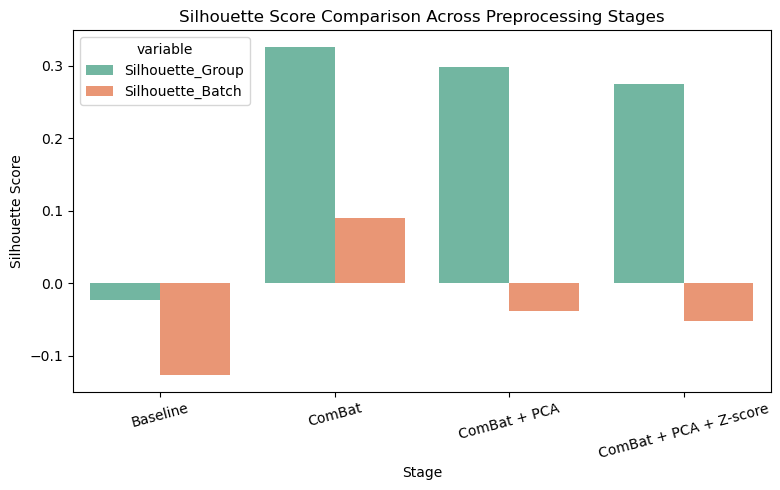

In [5]:
# ============================================================
# SECTION 5 — Comparison of uRF–UMAP Results Across All Pipelines
# ============================================================
"""
Goal:
To quantitatively compare all uRF–UMAP embeddings by Silhouette scores
for biological grouping (HRA vs LRA) and batch effects.
"""

def evaluate_umap(embedding, df_meta):
    """Compute silhouette scores for biological and batch structures."""
    df_tmp = df_meta.copy()
    df_tmp["uRF_UMAP1"], df_tmp["uRF_UMAP2"] = embedding[:, 0], embedding[:, 1]
    sil_group = silhouette_score(df_tmp[["uRF_UMAP1", "uRF_UMAP2"]], df_tmp["Group"])
    sil_batch = silhouette_score(df_tmp[["uRF_UMAP1", "uRF_UMAP2"]], df_tmp["Seq"])
    return sil_group, sil_batch


# --- Re-run embeddings to capture for each stage ---
# (We re-use proximity matrices computed earlier)
def get_umap_from_proximity(prox, df_meta):
    reducer = umap.UMAP(
        n_neighbors=15,
        min_dist=0.1,
        metric="precomputed",
        random_state=42
    )
    return reducer.fit_transform(1 - prox)


emb_baseline = get_umap_from_proximity(prox_baseline, df_real)
emb_combat = get_umap_from_proximity(prox_combat, df_real)
emb_pca = get_umap_from_proximity(prox_pca, df_real)
emb_final = get_umap_from_proximity(prox_final, df_real)

# --- Evaluate all embeddings ---
results = []
for name, emb in [
    ("Baseline", emb_baseline),
    ("ComBat", emb_combat),
    ("ComBat + PCA", emb_pca),
    ("ComBat + PCA + Z-score", emb_final)
]:
    sil_g, sil_b = evaluate_umap(emb, df_real)
    results.append({
        "Stage": name,
        "Silhouette_Group": round(sil_g, 3),
        "Silhouette_Batch": round(sil_b, 3),
        "Δ (Group - Batch)": round(sil_g - sil_b, 3)
    })

results_df = pd.DataFrame(results)

# --- Display table ---
print("\n=== uRF–UMAP Comparison Summary ===")
display(results_df.style.background_gradient(cmap="coolwarm", subset=["Δ (Group - Batch)"]))

# --- Visual summary ---
plt.figure(figsize=(8, 5))
sns.barplot(
    data=results_df.melt(id_vars="Stage", value_vars=["Silhouette_Group", "Silhouette_Batch"]),
    x="Stage", y="value", hue="variable", palette="Set2"
)
plt.title("Silhouette Score Comparison Across Preprocessing Stages")
plt.ylabel("Silhouette Score")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


## Section 5 — Comparison of uRF–UMAP Results Across Preprocessing Pipelines

The goal of this analysis is to evaluate how different preprocessing strategies 
affect the intrinsic structure of the VOC dataset, as visualized using 
Unsupervised Random Forest (uRF) combined with UMAP embedding.

For each pipeline : Baseline (no correction), ComBat batch correction*, ComBat + PCA smoothing*, and ComBat + PCA + Z-score normalization
two Silhouette scores were calculated:

- Silhouette (Group): measures how well biological classes (HRA vs LRA) are separated.  
- Silhouette (Batch): measures the degree of residual clustering by batch (`Seq`).

A high Group score indicates stronger biological signal, while a low Batch score 
indicates reduced technical or batch-driven variation.

The difference (Δ = Group − Batch) summarizes the balance between biological separation 
and batch effect removal.

Conclusion:
- The ComBat-corrected data achieved the best balance between biological signal and batch effect removal (Δ ≈ 0.35, there is stochasticity though but over several runs it stays the best). 
- The Baseline data showed poor structure, indicating strong technical noise before correction.
- PCA** and Z-score smoothing slightly reduced the biological contrast, likely due to mild over-normalization.
